In [1]:
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
import jsonpickle

from particle_filter import particlefilter
from pmcmc import particlemcmc
from math_utils import nbinom_logpmf

In [2]:
'''Import data'''

data = pd.read_csv('../data_sets/ou_SIRS_data_seasonal.csv').to_numpy()
state = pd.read_csv('../data_sets/ou_SIRS_state_seasonal.csv').to_numpy()
betas = pd.read_csv('../data_sets/ou_SIRS_betas_seasonal.csv').to_numpy()

In [3]:
# {"lambda": 0.1, "A": 0.2, "B": 0.05, "C": 0.5, "sig": 0.2}

def SIRS_model(particles,observations,t,dt,model_params,rng):
    '''Definition of SEIR model as described in Calvetti's paper. Difference 
    is the use of Tau leaping to introduce stochasticity into the system and continuous log-normal OU process definition for beta.'''
    gamma,xi,A,B,C,sig,rho,R = model_params

    lam = 1/10

    '''Tau leaping. Non estimated parameters are hard coded. '''

    for index in range(particles.shape[0]):

        new_I = rng.poisson((particles[index,3,t] * particles[index, 1, t]* particles[index, 0, t])/np.sum(particles[index,:,t]) * dt)
        new_S = rng.poisson((xi * particles[index,2,t]) * dt)
        new_R = rng.poisson((gamma * particles[index,1,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] - new_I + new_S) #S
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_I - new_R) #I
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_R - new_S) #R

        particles[index,3,t] = particles[index,3,t] + (-lam * (particles[index,3,t] - (A*np.cos(B * t) + C))) * dt + sig * np.sqrt(2 * lam)*rng.normal(0,dt)

        observations[index,0,t] = particles[index,1,t]

    return particles,observations

def SIRS_Obs(data_point, particle_observations, model_params):
    rho = model_params[4]
    r = 1/model_params[5]
    weights = nbinom_logpmf(x = data_point,p = r/(r + rho * (particle_observations[:,0] + 0.005)),n = np.array([r]))
    return weights


In [4]:
'''True parameter values'''
rng = np.random.default_rng(0)

'''unpickle parameter sets'''
with open("../param_sets/SIRS_OU_seasonal_model_params.json", "r+") as f:
    SIRS_model_json = f.read()
    SIRS_model_params = jsonpickle.decode(SIRS_model_json)

gamma = SIRS_model_params['gamma']
R = SIRS_model_params['R']
xi = SIRS_model_params['xi']
rho = SIRS_model_params['rho']

with open("../param_sets/SIRS_OU_seasonal_process_params.json", "r+") as f:
    OU_process_json = f.read()
    SIRS_OU_process_params = jsonpickle.decode(OU_process_json)

A = SIRS_OU_process_params['A']
B = SIRS_OU_process_params['B']
C = SIRS_OU_process_params['C']
sig = SIRS_OU_process_params['sig']

print(A,B,C,sig)

T = 365
dt = 0.1
t_vec = np.arange(0,T,dt)

def SIRS_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 5000
    I_init = rng.integers(1,5,size = (num_particles))
    R_init = rng.integers(1,3000,size = (num_particles))
    particles_0[:,0] -= I_init
    particles_0[:,0] -= R_init

    particles_0[:,1] = I_init
    particles_0[:,2] = R_init
    
    particles_0[:,3] = rng.uniform(0.,1., size = (num_particles,))
    

    return particles_0

pf_params = {'num_particles':100_000, 
                      'dt':dt,
                      'model':SIRS_model,
                      'observation_model':SIRS_Obs,
                      'model_dim':4,
                      'particle_initializer':SIRS_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= (gamma,xi,A,B,C,sig,rho,1/R),
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )

print(perf_counter() - t)

0.2 0.05 0.5 0.2


KeyboardInterrupt: 

 Log Likelihood : -2070.3605198821106
Root Mean Squared Error for the Data 328.2798829362135


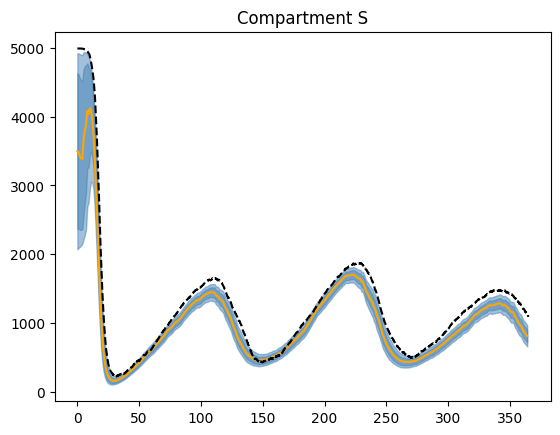

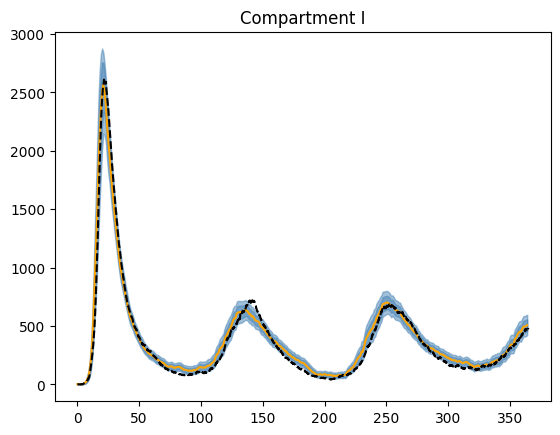

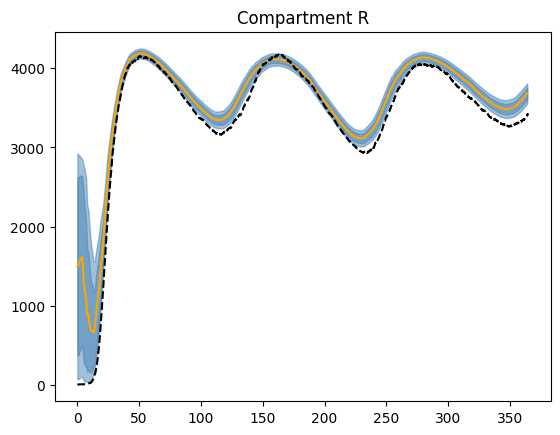

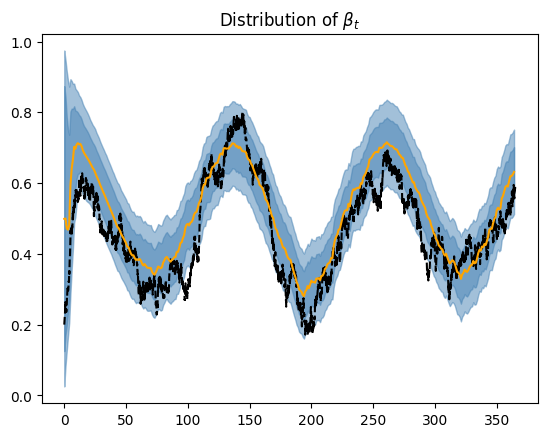

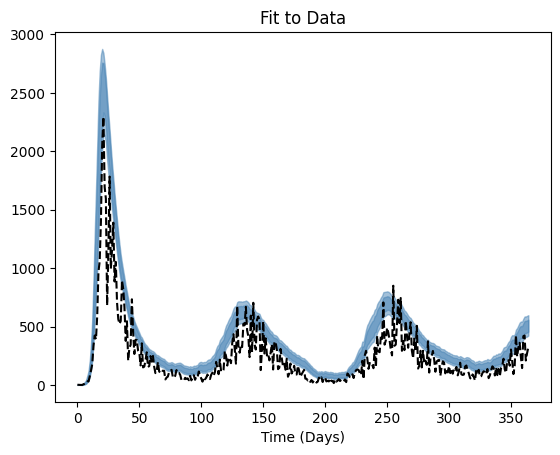

In [ ]:
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")

print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

labels = ['S','I','R']
for i in range(3):
    plt.title(f'Compartment {labels[i]}')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.plot(np.average(output['particle_distribution'][:,i,:],weights = np.exp(output['log_weights']),axis = 0),color = 'orange')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    plt.show()

plt.title('Distribution of $\\beta_t$')
plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,3,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,3,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,3,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,3,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.plot(np.average(output['particle_distribution'][:,3,:],weights = np.exp(output['log_weights']),axis = 0),color = 'orange')
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,2.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,12.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

In [ ]:
pmcmc_rng = np.random.default_rng(0)

@nb.njit
def uniform_numba_logpdf(theta,min_val,max_val):

    if(theta < max_val and theta > min_val):
        return np.log(1/(max_val - min_val))
    
    return np.log(0.)

#gamma,xi,A,B,C,sig,rho,1/R

def sirs_prior(theta):
    return uniform_numba_logpdf(theta[0],min_val= 1/28.,max_val= 1/7) + uniform_numba_logpdf(theta[1],min_val = 1/365.,max_val = 1/10.) + uniform_numba_logpdf(theta[2],min_val=0.,max_val=1.) + uniform_numba_logpdf(theta[3],min_val = 0.,max_val=1.) + uniform_numba_logpdf(theta[4],min_val = 0.,max_val=1.) + uniform_numba_logpdf(theta[5],min_val= 0.,max_val=1.) +  uniform_numba_logpdf(theta[6],min_val= 0.,max_val=1.) +  uniform_numba_logpdf(theta[7],min_val= 0.,max_val=1.)


'''estimated gamma,xi,A,B,C,sig,rho,1/R
0.1 0.008 0.2 0.05 0.5 0.2 0.7 0.1'''




pmcmc_params = {'iterations':100_000,
                'init_params':np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.01]),
                'prior':sirs_prior,
                'init_cov': np.diag([0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05]),
                'burn_in':10_000}

pf_params = {'num_particles':1_000, 
                      'dt':0.1,
                      'model':SIRS_model,
                      'observation_model':SIRS_Obs,
                      'model_dim':5,
                      'particle_initializer':SIRS_init
                      }

t = perf_counter()
pmcmc_output = particlemcmc(
                  data = data,
                  pmcmc_params=pmcmc_params,
                  pf_params=pf_params,
                  adaptive=True,
                  rng = rng,
                  req_jit=True
                  )
print(perf_counter() - t)

/Users/averydrennan/PMCMC/examples/../pmcmc.py:117: RuntimeWarning: invalid value encountered in scalar subtract
  ratio = (LL_new - LL[iter-1])


iteration: 10| Acceptance rate: 0.0| Log-Likelihood: -inf| Proposal [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.01]
iteration: 20| Acceptance rate: 0.0| Log-Likelihood: -inf| Proposal [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.01]
iteration: 30| Acceptance rate: 0.0| Log-Likelihood: -inf| Proposal [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.01]
iteration: 40| Acceptance rate: 0.0| Log-Likelihood: -inf| Proposal [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.01]
iteration: 50| Acceptance rate: 0.0| Log-Likelihood: -inf| Proposal [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.01]
iteration: 60| Acceptance rate: 0.0| Log-Likelihood: -inf| Proposal [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.01]
iteration: 70| Acceptance rate: 0.0| Log-Likelihood: -inf| Proposal [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.01]
iteration: 80| Acceptance rate: 0.0| Log-Likelihood: -inf| Proposal [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.01]
iteration: 90| Acceptance rate: 0.0| Log-Likelihood: -inf| Proposal [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.01]
iteration:

SystemError: CPUDispatcher(<function filter_internal at 0x11c08d4e0>) returned a result with an exception set